In [16]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import hilbert
from scipy.signal import butter, filtfilt



In [27]:

data = np.genfromtxt(
    "tests/evann cismag 2 RF.txt",
    delimiter=",",
    filling_values=0
)

data = data.T   # Fix orientation


In [28]:

def bandpass_filter(data, fs, lowcut, highcut, order=3):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut/nyq, highcut/nyq], btype='band')
    return filtfilt(b, a, data, axis=1)

# Example (adjust based on probe):
fs = 40e6        # 40 MHz sampling
lowcut = 3e6
highcut = 9e6

filtered = bandpass_filter(data, fs, lowcut, highcut)


In [29]:

analytic_signal = hilbert(data, axis=1)
envelope = np.abs(analytic_signal)


In [30]:
envelope = envelope / np.max(envelope)  # normalize
bmode = 20 * np.log10(envelope + 1e-6)


In [31]:
dynamic_range = 60

bmode = np.clip(bmode, -dynamic_range, 0)
bmode = (bmode + dynamic_range) / dynamic_range  # scale 0–1


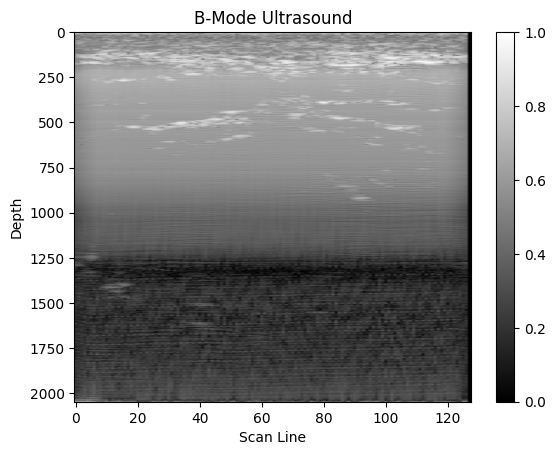

In [32]:

plt.imshow(bmode.T, cmap='gray', aspect='auto')
plt.xlabel("Scan Line")
plt.ylabel("Depth")
plt.title("B-Mode Ultrasound")
plt.colorbar()
plt.show()


RF data shape: (127, 2048)


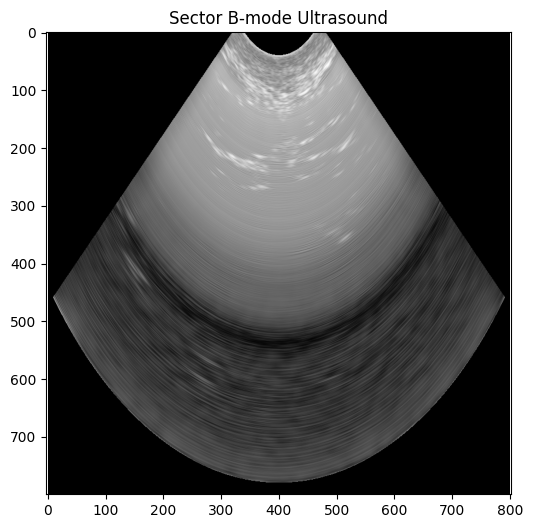

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(800, 800))

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy.interpolate import RegularGridInterpolator
from scipy.ndimage import gaussian_filter



def rf_to_sector_image(
    filepath,
    sector_angle_deg=60,
    dynamic_range=60,
    output_resolution=800
):
    """
    Convert raw RF ultrasound data (TXT) into a conical B-mode image.

    Parameters:
        filepath (str): path to RF txt file
        sector_angle_deg (float): total sector angle in degrees
        dynamic_range (float): dynamic range in dB
        output_resolution (int): output image size (square)

    Returns:
        cart_image (ndarray): sector image
    """

    # -------------------------
    # 1) Load RF data
    # -------------------------
    data = np.genfromtxt(
        filepath,
        delimiter=",",
        filling_values=0
    )

    data = data.T   # Fix orientation


    # Remove completely empty rows (if any)
    data = data[~np.all(data == 0, axis=1)]

    print("RF data shape:", data.shape)

    # -------------------------
    # 2) Envelope Detection
    # -------------------------
    analytic_signal = hilbert(data, axis=1)
    envelope = np.abs(analytic_signal)

    # -------------------------
    # 3) Log Compression
    # -------------------------
    envelope /= np.max(envelope) + 1e-12
    bmode = 20 * np.log10(envelope)


    bmode = np.clip(bmode, -dynamic_range, 0)
    bmode = (bmode + dynamic_range) / dynamic_range  # scale 0–1
    bmode = gaussian_filter(bmode, sigma=1)


    # -------------------------
    # 4) Define Polar Geometry
    # -------------------------
    num_lines, num_samples = bmode.shape

    sector_angle = np.deg2rad(sector_angle_deg)
    theta = np.linspace(-sector_angle/2, sector_angle/2, num_lines)
    # r = np.linspace(0, 1, num_samples)
    apex_offset = 0.15   # try between 0.1 and 0.4

    r = np.linspace(apex_offset, 1 + apex_offset, num_samples)
    r = np.power(r, 0.85)  # gamma correction on radius

    

    interp = RegularGridInterpolator(
        (theta, r),
        bmode,
        bounds_error=False,
        fill_value=0
    )

    # -------------------------
    # 5) Create Cartesian Grid
    # -------------------------
    r_min = apex_offset
    r_max = 1 + apex_offset

    # Horizontal limit determined by sector geometry
    x_max = r_max * np.sin(sector_angle / 2)

    x = np.linspace(-x_max, x_max, output_resolution)
    y = np.linspace(r_min, r_max, output_resolution)

    X, Y = np.meshgrid(x, y)

    R = np.sqrt(X**2 + Y**2)
    Theta = np.arctan2(X, Y)

    points = np.stack((Theta.ravel(), R.ravel()), axis=-1)
    cart_image = interp(points).reshape(output_resolution, output_resolution)

    # Mask outside sector
    # mask = (R <= 1) & (np.abs(Theta) <= sector_angle/2)
    mask = ( (R >= apex_offset) & (R <= 1.05 + apex_offset) & (np.abs(Theta) <= sector_angle/2) )
    cart_image[~mask] = 0

    # -------------------------
    # 6) Display
    # -------------------------
    plt.figure(figsize=(6,6))
    plt.imshow(cart_image, cmap='gray', origin='upper')
    plt.axis('equal')
    plt.title("Sector B-mode Ultrasound")
    plt.show()

    return cart_image


rf_to_sector_image("tests/evann cismag 2 RF.txt",
                   sector_angle_deg=100)


RF data shape: (127, 2048)


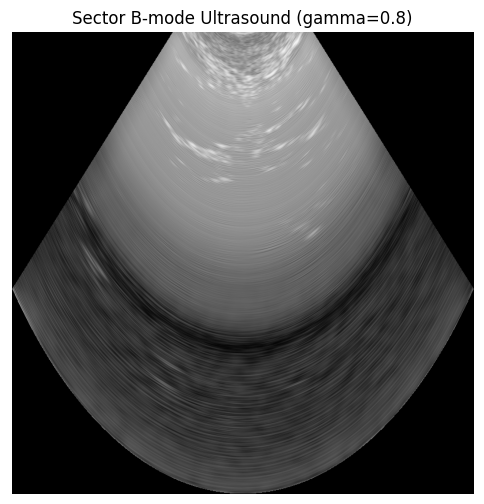

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(800, 800))

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy.interpolate import RegularGridInterpolator
from scipy.ndimage import gaussian_filter


def rf_to_sector_image(
    filepath,
    sector_angle_deg=60,
    dynamic_range=60,
    output_resolution=800,
    fs=40e6,   # RF sampling frequency (Hz)
    c=1540,    # speed of sound in tissue (m/s)
    gamma=1.0  # nonlinear radial stretch ( <1 stretches far field )
):
    """
    Convert raw RF ultrasound data (TXT) into a conical B-mode image
    with physical depth scaling and optional nonlinear radial mapping.

    Parameters:
        filepath (str): path to RF txt file
        sector_angle_deg (float): total sector angle in degrees
        dynamic_range (float): dynamic range in dB
        output_resolution (int): output image size (square)
        fs (float): RF sampling frequency in Hz
        c (float): speed of sound in m/s
        gamma (float): radial gamma correction (default=1.0, <1 stretches far field)

    Returns:
        cart_image (ndarray): sector image
    """

    # -------------------------
    # 1) Load RF data
    # -------------------------
    data = np.genfromtxt(filepath, delimiter=",", filling_values=0)
    data = data.T   # Fix orientation
    data = data[~np.all(data == 0, axis=1)]  # remove empty rows
    print("RF data shape:", data.shape)

    # -------------------------
    # 2) Envelope Detection
    # -------------------------
    analytic_signal = hilbert(data, axis=1)
    envelope = np.abs(analytic_signal)

    # -------------------------
    # 3) Log Compression
    # -------------------------
    envelope /= np.max(envelope) + 1e-12
    bmode = 20 * np.log10(envelope + 1e-6)
    bmode = np.clip(bmode, -dynamic_range, 0)
    bmode = (bmode + dynamic_range) / dynamic_range  # scale 0–1

    # Optional smoothing
    bmode = gaussian_filter(bmode, sigma=1)

    # -------------------------
    # 4) Define Polar Geometry (with physical depth)
    # -------------------------
    num_lines, num_samples = bmode.shape
    sector_angle = np.deg2rad(sector_angle_deg)
    theta = np.linspace(-sector_angle/2, sector_angle/2, num_lines)

    # Depth scaling: each sample corresponds to c/(2*fs) meters
    depths = np.arange(num_samples) * (c / (2 * fs))
    depths /= np.max(depths)  # normalize to [0,1]
    apex_offset = 0.15
    r = depths + apex_offset

    # Apply nonlinear radial mapping (gamma correction)
    r = np.power(r, gamma)

    interp = RegularGridInterpolator(
        (theta, r),
        bmode,
        bounds_error=False,
        fill_value=0
    )

    # -------------------------
    # 5) Create Cartesian Grid
    # -------------------------
    r_min = np.min(r)
    r_max = np.max(r)
    x_max = r_max * np.sin(sector_angle / 2)

    x = np.linspace(-x_max, x_max, output_resolution)
    y = np.linspace(r_min, r_max, output_resolution)
    X, Y = np.meshgrid(x, y)

    R = np.sqrt(X**2 + Y**2)
    Theta = np.arctan2(X, Y)

    points = np.stack((Theta.ravel(), R.ravel()), axis=-1)
    cart_image = interp(points).reshape(output_resolution, output_resolution)

    # Mask outside sector
    mask = (
        (R >= r_min) &
        (R <= r_max) &
        (np.abs(Theta) <= sector_angle/2)
    )
    cart_image[~mask] = 0

    # -------------------------
    # 6) Display
    # -------------------------
    plt.figure(figsize=(6,6))
    plt.imshow(cart_image, cmap='gray', origin='upper', vmin=0, vmax=1)
    plt.axis('equal')
    plt.axis('off')
    plt.title("Sector B-mode Ultrasound (gamma={})".format(gamma))
    plt.show()

    return cart_image

rf_to_sector_image("tests/evann cismag 2 RF.txt",
                   sector_angle_deg=100,
                   gamma=0.8)
